<a href="https://colab.research.google.com/github/KianShokraneh/Captum-Interpretability-Demonstrations/blob/main/CAPTUM_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Captum Library**
Captum offers a variety of techniques to interpret model predictions and understand how different features contribute to the output.

### Key Features:

1. **Integrated Gradients**: This technique attributes the prediction of a neural network to its input features by integrating the gradients of the output with respect to the input.

2. **Saliency Maps**: These maps highlight the regions in the input that are most important for the model's predictions.

3. **Layer-wise Relevance Propagation (LRP)**: This method decomposes the prediction of the neural network and attributes relevance to each input feature.

4. **DeepLift**: DeepLift assigns importance scores to the input features based on the changes in the output when the input features change from a reference value.

5. **Shapley Values**: This approach uses concepts from cooperative game theory to attribute the contribution of each feature to the model’s prediction.

6. **Feature Ablation**: This method involves systematically removing each feature to see how the absence of that feature impacts the model's prediction.

7. **Visualization Tools**: Captum provides tools for visualizing the attributions and understanding the model's behavior in a more intuitive way.


In [ ]:
!pip install torch torchvision captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('drive/MyDrive/resnet18_cifar10.pth'))
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

100%|██████████| 170498071/170498071 [00:05<00:00, 31574198.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


#**Grad-cam**

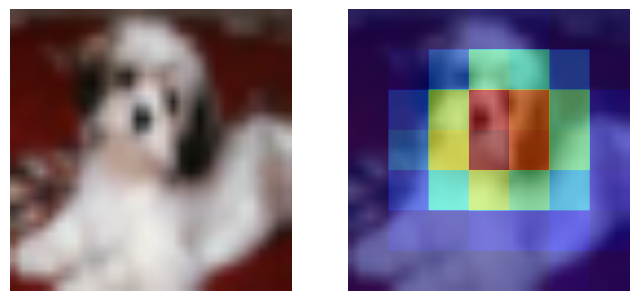

In [ ]:
random_index = random.randint(0, len(cifar10) - 1)
img, label = cifar10[9146]

input_batch = img.unsqueeze(0).to(device)

output = model(input_batch)
predicted_class = output.argmax(dim=1).item()

target_layer = model.layer4[1].conv2

gradcam = LayerGradCam(model, target_layer)

attributions = gradcam.attribute(input_batch, target=predicted_class)

attributions = LayerAttribution.interpolate(attributions, (224, 224))

attributions_np = attributions.squeeze().cpu().detach().numpy()
attributions_np = np.maximum(attributions_np, 0)
attributions_np = attributions_np / attributions_np.max()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(transforms.ToPILImage()(img))
ax[0].axis('off')
ax[1].imshow(transforms.ToPILImage()(img))
ax[1].imshow(attributions_np, cmap='jet', alpha=0.5)
ax[1].axis('off')
plt.show()

#**IntegratedGradients**

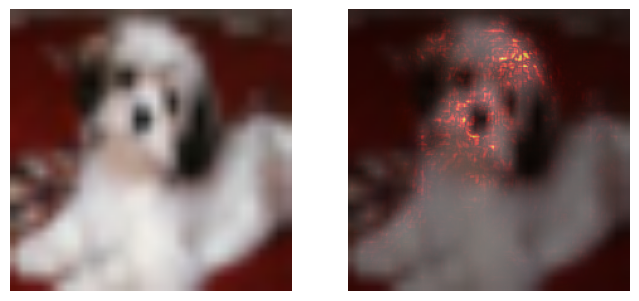

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients
import random

ig = IntegratedGradients(model)
baseline = torch.zeros_like(input_batch)

attributions, delta = ig.attribute(input_batch, baseline, target=predicted_class, return_convergence_delta=True)

attributions = attributions.squeeze().cpu().detach().numpy()
attributions = np.transpose(attributions, (1, 2, 0))
attributions = np.sum(np.abs(attributions), axis=2)
attributions = attributions / attributions.max()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(transforms.ToPILImage()(img))
ax[0].axis('off')
ax[1].imshow(transforms.ToPILImage()(img))
ax[1].imshow(attributions, cmap='hot', alpha=0.5)
ax[1].axis('off')
plt.show()


#**Gradient Shap**

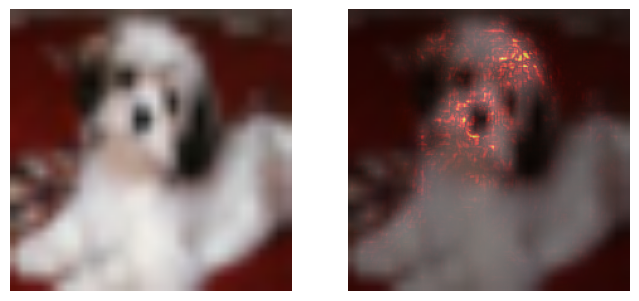

In [ ]:
from captum.attr import GradientShap

gs = GradientShap(model)

baseline_dist = torch.cat([input_batch * 0, input_batch * 1])

attributions = gs.attribute(input_batch, baselines=baseline_dist, target=predicted_class, n_samples=50)

attributions = attributions.squeeze().cpu().detach().numpy()
attributions = np.transpose(attributions, (1, 2, 0))
attributions = np.sum(np.abs(attributions), axis=2)
attributions = attributions / attributions.max()

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(transforms.ToPILImage()(img))
ax[0].axis('off')
ax[1].imshow(transforms.ToPILImage()(img))
ax[1].imshow(attributions, cmap='hot', alpha=0.5)
ax[1].axis('off')
plt.show()